In [1]:
# uploading the important libraries and functions that will be used in the analysis 
config = {}
config = {'basedir': '/Volumes/MacBack/GenzelLab/VitorCode/QinnonThetaFreq/dlt2/aquinn/ThetaShapeExample/data_dist',
          'figdir': None,
          'datadir': None,
          'analysisdir': '/Volumes/MacBack/GenzelLab/VitorCode/QinnonThetaFreq/dlt2/aquinn/ThetaShapeExample/data_dist'}
config['1col_width'] = 85
config['2col_width'] = 114
config['3col_width'] = 174
config['fontname'] = 'Helvetica'

config['recordings'] = ['mdm81-2311-0128_2',
                        'mdm81-2311-0128_5',
                        'mdm90-1901-0127_2',
                        'mdm90-1901-0127_5',
                        'mdm96-1806-0121_2',
                        'mdm96-1806-0121_6']

config['tetrode_inds'] = [25, 25, 9, 9, 33, 33]

import re
import emd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal, stats, ndimage
from scipy import ndimage, interpolate
import logging 
import pandas as pd
import glmtools as glm
from scipy import stats
from matplotlib.colors import ListedColormap
import scipy.io
matplotlib.rc('font', serif=config['fontname'])



def my_range(x):
    return x.max() - x.min()

def compute_range(x):
    return x.max() - x.min()


def asc2desc(x):
    """Ascending to Descending ratio ( A / A+D )."""
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    """Peak to trough ratio ( P / P+T )."""
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)

def decorate_ax(ax):
    for tag in ['top', 'right']:
        ax.spines[tag].set_visible(False)
        
def load_tracking(whl_path, new_len, smoothing=1):
    """Load position data from .whl file"""
    track = np.genfromtxt( whl_path )
    track[track<0] = np.nan
    if smoothing is not None:
            track = ndimage.filters.gaussian_filter1d(track, smoothing, axis=0)

    pixels2bins = 37 / (np.nanmax(track[:,0])-np.nanmin(track[:,0])) * 1/32. * 1250
    velx = np.gradient(track[:,0])
    vely = np.gradient(track[:,1])
    speed = np.sqrt(pow(velx,2)+pow(vely,2))

    # Upsample to match LFP data
    factor = 1250/32
    f = interpolate.interp1d( np.linspace(0,track.shape[0]/factor,track.shape[0]), speed,
                       kind='nearest', bounds_error=False)
    big_speed= f( np.linspace(0,new_len/1250, new_len) )*pixels2bins

    return big_speed

def load_dataset(run_id):
    logger = logging.getLogger('emd')

    inds = np.where([r == run_id for r in config['recordings']])[0][0]
    fileName = config['recordings'][inds]+'.eeg'
    logger.info('Loading data from: {0}'.format(fileName))
    raw = np.fromfile(fileName, dtype=np.int16).astype(float)
    raw = raw.reshape(-1,64)[:,config['tetrode_inds'][inds]]
    sample_rate = 1250
    seconds = raw.shape[0] / sample_rate
    time = np.linspace(0,seconds,raw.shape[0])
    logger.info('Loaded {0} seconds of data'.format(seconds))
    fileWhl = config['recordings'][inds]+'.whl'
    logger.info('Loading tracking from: {0}'.format(fileWhl))
    speed = load_tracking(fileWhl, time.shape[0], smoothing=16)

    return raw, speed, time, sample_rate

def getIMFmainfreq(If, Ia):
    '''
    If the instantaneous frequency extracted from imfs
    Ia instantenous amplitude 
    '''
    IF = If.transpose()
    IA = Ia.transpose()

    nimfs = np.size(IA,0)

    mainfreqs = np.zeros(nimfs)+np.nan
    for imfi in range(0,nimfs):
        if0 = np.copy(IF[imfi,1:-1])
        ia0 = np.copy(IA[imfi,1:-1])
        mainfreqs[imfi] = np.sum(if0*pow(ia0,2))/np.sum(pow(ia0,2))
    return mainfreqs


def remove_frames(ax, tags=['top', 'right']):
    for tag in tags:
        ax.spines[tag].set_visible(False)

def decorate(ax, mode='timex', bottom_row=True):
    for tag in ['top', 'right']:
        ax.spines[tag].set_visible(False)
    if mode == 'phasex':
        if bottom_row:
            xlabels = ['-pi', '-pi/2', '0', 'pi/2', 'pi']
            ax.set_xlabel('Theta Phase (rads)')
        else:
            xlabels = []
        ax.set_xticks(np.linspace(0, 48, 5))
        ax.set_xticklabels(xlabels)
    elif mode == 'timex':
        if bottom_row:
            xlabels = np.arange(5)*50
            ax.set_xlabel('Time (samples)')
        else:
            xlabels = []
        ax.set_xticks(np.arange(5)*50)
        ax.set_xticklabels(xlabels)
    elif mode == 'normx':
        if bottom_row:
            xlabels = np.linspace(0, 1, 3)
            ax.set_xlabel('Proportion of sinusoid')
        else:
            xlabels = []
        ax.set_xticks(np.linspace(0, 48, 3))
        ax.set_xticklabels(xlabels)

def shift_ax(ax, shift):
    pos = list(ax.get_position().bounds)
    pos[0] = pos[0] + shift
    ax.set_position(pos)

def phase_from_freq(ifrequency, sample_rate, phase_start=-np.pi):
    """
    Compute the instantaneous phase of a signal from its instantaneous phase.
    Parameters
    ----------
    ifrequency : ndarray
        Input array containing the instantaneous frequencies of a signal
    sample_rate : scalar
        The sampling frequency of the data
    phase_start : scalar
         Start value of the phase output (Default value = -np.pi)
    Returns
    -------
    IP : ndarray
        The instantaneous phase of the signal
    """

    iphase_diff = (ifrequency / sample_rate) * (2 * np.pi)

    iphase = phase_start + np.cumsum(iphase_diff, axis=0)

    iphase = np.r_[phase_start, iphase]

    return iphase

def get_cycle_examples():
    from scipy import interpolate
    freq = 8
    seconds = 2/freq
    num_samples = 3124

    time_vect = np.linspace(0, seconds, num_samples)

    phs = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
    tim2 = [0, 390-100, 781, 1171+100, 1562]
    tim3 = [0, 390+100, 781, 1171-100, 1562]
    tim4 = [0, 390-150, 781, 1171+150, 1562]

    pin2 = interpolate.interp1d(tim2, phs, kind='quadratic')
    pin3 = interpolate.interp1d(tim3, phs, kind='quadratic')
    pin4 = interpolate.interp1d(tim4, phs, kind='quadratic')

    xx2 = pin2(np.arange(1562))
    xx3 = pin3(np.arange(1562))
    xx4 = pin4(np.arange(1562))

    x = np.zeros((3124, 5))
    x[:, 0] = -np.cos(2*np.pi*8*time_vect)
    x[:, 1] = np.r_[np.sin(xx4), np.sin(xx4), np.sin(xx4)][1171:1171+3124]
    x[:, 2] = np.flipud(x[:, 1])
    x[:, 3] = -np.r_[np.cos(xx2), np.cos(xx2)]
    x[:, 4] = -np.r_[np.cos(xx3), np.cos(xx3)]
    return time_vect, x

def add_circles(ax, waves=False, sines=False,
                wave_len=.5, wave_height=1, offset=3):

    x_polar = np.linspace(0, 2*np.pi, 128)
    factor = np.array([.5, 1])*2
    for f in factor:
        ax.plot(f*np.sin(x_polar), f*np.cos(x_polar), 'k', linewidth=.75)
    ax.plot((-2.5, 2.5), (0, 0), 'k', linewidth=.75)
    ax.plot((0, 0), (-2.5, 2.5), 'k', linewidth=.75)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)
    ax.set_xticks([])
    ax.set_yticks([])

    tv, canonical_cycles = get_cycle_examples()
    canonical_cycles = canonical_cycles*wave_height
    tv /= 15
    tv2 = np.linspace(0, wave_len, 3124)

    if sines:
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 0]-offset, 'k', linewidth=.5)
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 0]+offset, 'k', linewidth=.5)
        ax.plot(tv2-offset-wave_len/2, canonical_cycles[:, 0], 'k', linewidth=.5)
        ax.plot(tv2+offset-wave_len/2, canonical_cycles[:, 0], 'k', linewidth=.5)

    if waves:
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 3]-offset, 'k')
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 4]+offset, 'k')
        ax.plot(tv2-offset-wave_len/2, canonical_cycles[:, 2], 'k')
        ax.plot(tv2+offset-wave_len/2, canonical_cycles[:, 1], 'k')
        

def normalised_waveform(infreq, sample_rate):
    sr = infreq.mean() * len(infreq)
    phase_diff = (infreq / sr) * (2 * np.pi)
    phase = np.cumsum(phase_diff, axis=0)
    phase = np.r_[0, phase]
    sine = np.sin(np.linspace(0, 2*np.pi, len(phase)))
    nw = np.sin(phase)

    return nw, sine

def scatter_kde(x, y):
    # Calculate the point density
    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)

    # KDE colouring
    plt.scatter(x, y, c=z, s=5, edgecolor=['none'])

def extract_title(fname):
   # Define a single regex pattern to capture both rat number and "SD" part
   pattern = r'Rat(\d+).*?SD(\d+)'
   
   # Use re.search to find matches in the filename
   match = re.search(pattern, fname)
   
   # Check if a match is found
   if match:
       rat_number = match.group(1)  # Extract the rat number from the first captured group
       sd_number = match.group(2)   # Extract the "SD" number from the second captured group
   else:
       return 'none'
   
   return 'Rat_' + rat_number + ' SD_' + sd_number

Rat_3 SD_16
/home/miranjo/REM_Phasic-Tonic/data/rat3/Rat_OS_Ephys_cbd_chronic_Rat3_407698_SD16_OR_20210701/2021-07-02_12-28-46_posttrial4
(241313,)


Text(0, 0.5, 'Amplitude $\\mu$V')

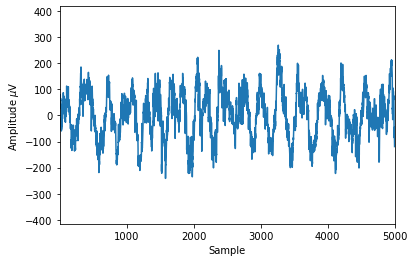

In [2]:
from utils import find_REM, load_data
REM_files = find_REM()

rem = REM_files[0]
dataREM = load_data(rem)
lfpREM = dataREM[0]

title = extract_title(str(rem))
print(title) 

print(rem.parent)
print(lfpREM.shape)

# Now plotting the data to inspect them
plt.plot(lfpREM)
plt.xlim((1,5000))
plt.xlabel('Sample')
plt.ylabel('Amplitude $\mu$V')


(5.0, 10.0)

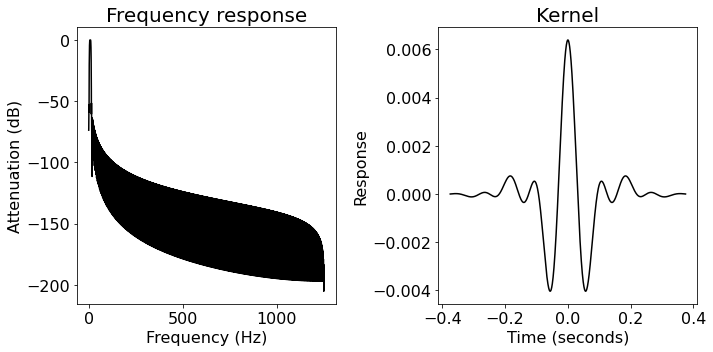

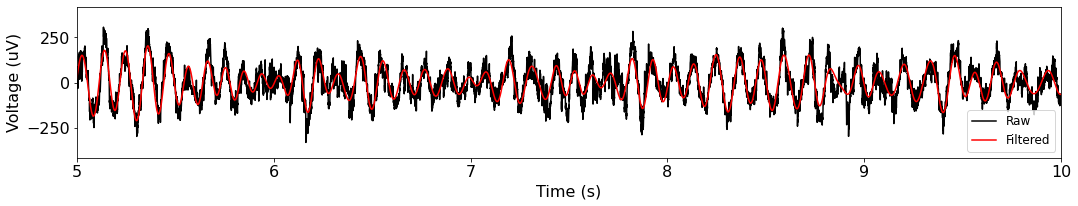

In [3]:
from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series

# Filter settings
f_theta = (4, 12)
f_lowpass = 25
n_seconds_filter = .5  # could be changed to 0.1
n_seconds_theta = .75
fs = 2500


#Filtering the signal
sig_low = filter_signal(lfpREM, 1000, 'lowpass', f_lowpass, n_seconds=n_seconds_filter, remove_edges=False)
sig_filt = filter_signal(lfpREM, fs, 'bandpass', f_theta, n_seconds=.75, plot_properties=True, remove_edges=False)

times = np.arange(0, len(lfpREM)/fs, 1/fs)

theta = sig_filt

plot_time_series(times, [lfpREM, theta], ['Raw', 'Filtered'])
plt.xlim(5, 10)

In [4]:
IP, IF, IA = emd.spectra.frequency_transform(theta, fs, 'hilbert', smooth_phase=3)
IP.shape

(241313, 1)

In [5]:
C = emd.cycles.Cycles(IP.flatten())
display(C)

<class 'emd.cycles.Cycles'> (708 cycles 1 metrics) 

In [6]:
# computing the cycle metrics 
C.compute_cycle_metric('start_sample', np.arange(len(C.cycle_vect)), emd.cycles.cf_start_value)
C.compute_cycle_metric('stop_sample', theta, emd.cycles.cf_end_value)
C.compute_cycle_metric('peak_sample', theta, emd.cycles.cf_peak_sample)
C.compute_cycle_metric('desc_sample', theta, emd.cycles.cf_descending_zero_sample)
C.compute_cycle_metric('trough_sample', theta, emd.cycles.cf_trough_sample)
C.compute_cycle_metric('duration_samples', theta, len)

C.compute_cycle_metric('max_amp', IA, np.max)
C.compute_cycle_metric('mean_if', IF, np.mean)
C.compute_cycle_metric('max_if', IF, np.max)
C.compute_cycle_metric('range_if', IF, compute_range)

C.compute_cycle_metric('asc2desc', theta, asc2desc)
C.compute_cycle_metric('peak2trough', theta, peak2trough)

print('Finished computing the cycles metrics')

Finished computing the cycles metrics


In [7]:
# Extract subset of the cycles 
amp_thresh = np.percentile(IA, 25)
lo_freq_duration = fs/5
hi_freq_duration = fs/12
conditions = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'max_amp>{amp_thresh}']

C.pick_cycle_subset(conditions)

In [8]:
display(C)

<class 'emd.cycles.Cycles'> (708 cycles 612 subset 69 chains - 14 metrics) 

In [9]:
df = C.get_metric_dataframe(conditions=conditions)

dist1 = df['max_amp']
dist2 = df['asc2desc']
dist3 = df['peak2trough']
dist4 = df['mean_if']

df.head()

,index,is_good,start_sample,stop_sample,peak_sample,desc_sample,trough_sample,duration_samples,max_amp,mean_if,max_if,range_if,asc2desc,peak2trough,chain_ind
0,1,1,303,-1.131967,101.82148,196.093093,282.142839,361,119.795496,6.916477,8.302221,2.191362,0.500495,0.543194,0
1,2,1,664,-0.377009,67.503182,141.424424,211.766484,289,112.072061,8.657272,9.090717,1.249985,0.500819,0.489358,0
2,3,1,953,-0.004368,82.214876,163.921922,240.016236,342,87.832449,7.312627,7.834274,1.739488,0.538593,0.479304,0
3,4,1,1295,-0.172139,111.940302,190.408408,271.0436,355,67.919135,7.040358,7.941801,2.218722,0.551822,0.536362,0
4,5,1,1650,-1.527936,121.29787,209.155155,297.799798,378,113.009658,6.602966,7.577647,2.275735,0.533064,0.553321,0


Text(0.5, 0.98, 'Rat_3 SD_16')

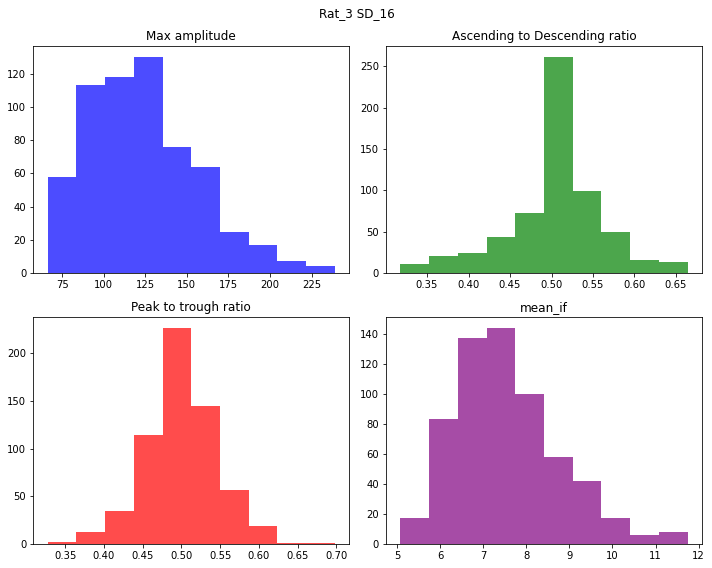

In [10]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(10,8))
n_bins = 10

# Plot the histograms with titles
axs[0, 0].hist(dist1, bins=n_bins, color='blue', alpha=0.7)
axs[0, 0].set_title('Max amplitude')

axs[0, 1].hist(dist2, bins=n_bins, color='green', alpha=0.7)
axs[0, 1].set_title('Ascending to Descending ratio')

axs[1, 0].hist(dist3, bins=n_bins, color='red', alpha=0.7)
axs[1, 0].set_title('Peak to trough ratio')

axs[1, 1].hist(dist4, bins=n_bins, color='purple', alpha=0.7)
axs[1, 1].set_title('mean_if')

plt.suptitle(title)

In [15]:
from bycycle.features import compute_features
from bycycle.plts import plot_burst_detect_param


threshold_kwargs = {'amp_fraction_threshold': 0.8,
                        'amp_consistency_threshold': 0,
                        'period_consistency_threshold': 0,
                        'monotonicity_threshold': 0,
                        'min_n_cycles': 8}

df = compute_features(theta, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')

#Extract Phasic and Tonic states
df_theta_phasic = df[df['is_burst']]
df_theta_tonic  = df[df['is_burst' ] == False]

len(df_theta_phasic)

0

In [19]:
df

,amp_fraction,amp_consistency,period_consistency,monotonicity,period,time_peak,time_trough,volt_peak,volt_trough,time_decay,...,time_rdsym,time_ptsym,band_amp,sample_peak,sample_last_zerox_decay,sample_zerox_decay,sample_zerox_rise,sample_last_trough,sample_next_trough,is_burst
0,0.603399,NaN,NaN,1.000000,367,199,160,99.992136,-89.518250,180,...,0.509537,0.554318,99.543321,405,145,504,305,218,585,False
1,0.552408,0.813508,0.792916,1.000000,291,142,154,96.949266,-119.792761,144,...,0.505155,0.479730,99.624735,732,504,800,658,585,876,False
2,0.344193,0.764196,0.849866,1.000000,317,158,154,87.092130,-79.372202,158,...,0.501577,0.506410,80.004001,1035,800,1112,954,876,1193,False
3,0.138810,0.764196,0.849866,1.000000,373,214,167,49.105774,-74.000992,159,...,0.573727,0.561680,59.455983,1407,1112,1493,1279,1193,1566,False
4,0.307365,0.753708,0.918848,1.000000,382,224,155,65.318428,-67.420389,177,...,0.536649,0.591029,75.477959,1771,1493,1872,1648,1566,1948,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,0.155807,0.829213,0.828571,0.897351,455,228,217,59.656536,-68.223003,153,...,0.663736,0.512360,45.683112,239564,239193,239638,239410,239262,239717,False
702,0.351275,0.771066,0.828571,1.000000,377,198,172,77.683542,-66.582261,183,...,0.514589,0.535135,84.087555,239911,239638,240008,239810,239717,240094,False
703,0.259207,0.316625,0.594306,1.000000,334,156,168,84.858960,-109.415547,166,...,0.502994,0.481481,74.060932,240262,240008,240332,240176,240094,240428,False
704,0.004249,0.316625,0.371886,0.865044,562,151,452,15.555402,-16.554647,110,...,0.804270,0.250415,9.283722,240880,240332,240935,240784,240428,240990,False
